<img src="//upload.wikimedia.org/wikipedia/commons/thumb/7/79/Yzr_logo_logo-bold-bleufonce.svg/langfr-1920px-Yzr_logo_logo-bold-bleufonce.svg.png">

*Exercice réalisé par Michel Nguyen.*

**CONSIGNES**

you'll find attached data about cars. This data contains 2 columns that interest us the most: "all equipments" and "main equipments":

Each line refers to a car, "all equipments" to a long list of all equipments in that car, and "main equipments" to only the main ones, there are 13 unique main equipments:

**{'4 roues motrices (4x4)',
 '7 places',
 'Android Auto',
 'Apple Car Play',
 'Bluetooth',
 'Caméra de recul',
 'Climatisation',
 'GPS',
 'Intérieur cuir',
 'Jantes alliage',
 'Radar de recul',
 'Régulateur de vitesse',
 'Toit ouvrant/panoramique'}**
 
The goal of this test is to predict the main equipments (exhaustive list only) from the column "all_equipments" of each car.
You will find in the data the main equipments for the 100 first cars, in order to give you an idea of what the result should look like. 

NB: Sometimes it's not written "GPS" in "all equipments" that you can easily predict that GPS exists in that car. Sometimes it's  just written "peugeot e connect" in "all equipments" and it means that the "main equipments" GPS and Bluetooth and Apple Car Play are included in that car. 
Therefore your approach can be semantic and/or lexical and/or other ideas.

Finally, create an API that takes as an input a string containing the big list of equipments and returns back the main equipments found  as an output. 

Bonus: For the bravest ones you can add a docker script that can create a container of your project.

Final result:

    all python scripts (well commented)
    a jupyter notebook version where you explain the algorithm part
    More files that you judge useful or necessary for this test or for me to run your code.


PS: There is no GOOD or BAD solution for this test, it's a large problem that can be handled in multiple ways (semantic and/or lexical).

**FIN DES CONSIGNES**

# Sommaire

1. [Import des librairies](#import)
2. [Prise en charge des données](#paragraph1)
3. [Stratégie](#paragraph3)
4. [Exploration élémentaire](#paragraph2) 
5. [Normalisation des données](#paragraph4)
5. [Extraction des échantillons](#paragraph5)
6. [Modèle de prédiction](#paragraph6)
7. [API](#paragraph7)
8. [Références](#paragraph8)  

## Import des librairies <a name="import"></a>

In [1]:
# analyse des données
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# extraction des échantillons, mesures de qualité, modèles de prédictions
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import metrics

# normalisation des données
import re
from nltk.stem.porter import PorterStemmer 
from nltk.corpus import stopwords

# sauvegarde  du modèle
import pickle

## Prise en charge des données <a name="paragraph1"></a>

In [2]:
df = pd.read_csv('cars_data.csv', sep=";")

In [3]:
df.head(5)

,export_date,offer_database_id,offer_brand,offer_model,offer_technical_motorization_value,all_equipments,main_equipments
0,17/03/2021 11:00,238264,Peugeot,308,1.5 BlueHDi 130 EAT8,Visiopark 1 Caméra de recul avec restitution s...,"Android Auto, Apple Car Play, Bluetooth, Camér..."
1,17/03/2021 11:00,449072,Peugeot,2008,1.2 PureTech 110 BVM5,"Aide au stationnement AR, Air conditionné auto...","Android Auto, Apple Car Play, Bluetooth, Camér..."
2,17/03/2021 11:00,235941,Citroën,C3 Aircross,1.2 PureTech 110 BVM6,"Allumage automatique des feux de croisement, D...","Bluetooth, Climatisation, Régulateur de vitess..."
3,17/03/2021 11:00,240680,Peugeot,308,BLUEHDI 100CH S S BVM6,Rétroviseurs extérieurs rabattables électrique...,"Bluetooth, Jantes alliage"
4,17/03/2021 11:00,449970,Peugeot,5008,1.5 BlueHDi 130 EAT8,"Kit anti-crevaison, Déclenchement automatique ...","7 places, Android Auto, Apple Car Play, Blueto..."


In [4]:
df.tail(5)

,export_date,offer_database_id,offer_brand,offer_model,offer_technical_motorization_value,all_equipments,main_equipments
5089,17/03/2021 11:00,441393,Peugeot,5008,1.5 BlueHDi 130 BVM6,"7 places, Accoudoir central, Android Auto, App...",NaN
5090,17/03/2021 11:00,237184,Seat,Ateca,1.6 TDI 115 CH START STOP STYLE,Accoudoir central réglable également en hauteu...,NaN
5091,17/03/2021 11:00,237178,Renault,Mégane 4 Estate Nouvelle,TCE 115 FAP,"Projecteurs avant Full LED Pure Vision, Lève-v...",NaN
5092,17/03/2021 11:00,238657,Citroën,C5 Aircross,2.0 BlueHDi 180 EAT8,Pack Drive Assist : Alerte Attention Conducteu...,NaN
5093,17/03/2021 11:00,450338,Renault,Clio 4,0.9 TCe 90 BVM5,"Media Nav Evolution (Navigation, cartographie ...",NaN


Le jeu de données s'inscrit dans le domaine des voitures. Ce qui nous intéresse, ce sont deux attributs : 'all_equipments' et 'main_equipments'.

L'attribut '**all_equipments**' correspond à une description exhaustive de la voiture. Il s'agit d'une liste de tous ses équipements.


L'attribut '**main_equipments**' correspond à une description simplifiée de la voiture. Il s'agit d'une liste de ses équipements principaux. On considéra chaque équipement principal comme un tag dans la suite du notebook.

## Stratégie <a name="paragraph3"></a>

Seules les 100 premières voitures possèdent une description "main_equipments" complète. C'est pourquoi notre jeu de données d'apprentissage se basera sur ces 100 premières voitures.

Ensuite, on supprimera les attributs inutiles pour la prédiction. Ce sont les attributs 'export_date', 'offer_brand', 'offer_model','offer_technical_motorization_value'.

On assura qu'il n'y a pas de duplication dans nos données grâce à l'attribut 'offer_database_id', puis on retire cet attribut.

In [5]:
# on ne prend que les 100 premières voitures 
df = df.iloc[:99, :]

In [6]:
# on retire les attributs inutiles
df = df.drop(['export_date', 'offer_brand', 'offer_model','offer_technical_motorization_value'] , axis=1)
print(" Dimensions du dataframe : ", df.shape)

 Dimensions du dataframe :  (99, 3)


In [7]:
# vérifier s'il y a des lignes dupliquées
duplicate_pairs = df.sort_values('offer_database_id', ascending=False).duplicated('offer_database_id')
print("Total de nombre d'ID dupliqué : ", duplicate_pairs.sum())

# on retire les éléments dupliqués
df = df[~duplicate_pairs]
print("Dimensions du dataframe après avoir retiré : ", df.shape)

# on retire l'attribut 'offer_database_id'
df = df.drop(['offer_database_id'],axis=1)

Total de nombre d'ID dupliqué :  3
Dimensions du dataframe après avoir retiré :  (96, 3)


<ipython-input-7-b5280e70861e>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~duplicate_pairs]


## Exploration élémentaire <a name="paragraph2"></a>

### Concernant l'attribut 'all_equipments' <a name="subparagraph2"></a>

In [8]:
# on cherche à mesurer la longueur de l'attribut 'all_equipments'
lens = df.all_equipments.str.len()
print("La longueur moyenne est :", lens.mean()) 
print("L'écart-type est :", lens.std()) 
print("La longueur maximale est :", lens.max()) 
print("La longueur minimale est :", lens.min())

La longueur moyenne est : 2057.25
L'écart-type est : 1371.9906014715682
La longueur maximale est : 7445
La longueur minimale est : 151


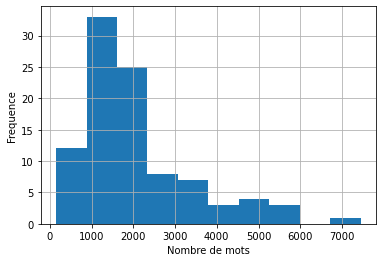

In [9]:
# visualisation de 'all_equipments'
lens.hist()
plt.xlabel("Nombre de mots")
plt.ylabel("Frequence")
plt.show()

**Observations :**
    

1. Nombre moyen de mots : 1494.
2. Nombre minimal de mots : 116.
3. Nombre maximal de mots : 5337.
4. 80% des descriptions ont entre 522 et 2466 mots.

### Concernant l'attribut 'main_equipments' <a name="subparagraph3"></a>

In [10]:
# on souhaite mesurer les tags en exploitant l'attribut 'main_equipments'
df['tag_count'] = df['main_equipments'].apply(lambda x : len(x.split(", ")))

In [11]:
print("Le nombre moyen de tags est : ", df['tag_count'].mean())
print("L'écart-type est : ", df['tag_count'].std(axis=0))
print("Le premier quartile est :", df['tag_count'].quantile(0.25))
print("La médianne est :", df['tag_count'].quantile(.5))
print("Le troisième quartile est : ", df['tag_count'].quantile(0.75))
print("Le nombre maximal de tags est :", df['tag_count'].max())
print("Le nombre minimal de tags est :", df['tag_count'].min())

Le nombre moyen de tags est :  6.822916666666667
L'écart-type est :  2.4148435349408484
Le premier quartile est : 5.0
La médianne est : 7.0
Le troisième quartile est :  9.0
Le nombre maximal de tags est : 11
Le nombre minimal de tags est : 1


Text(0, 0.5, 'Frequence')

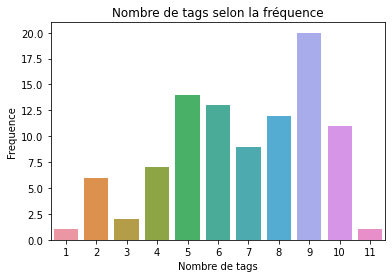

In [12]:
# visualisation du nombre des tags sur un diagramme en bar
sns.countplot(df['tag_count'])
plt.title("Nombre de tags selon la fréquence")
plt.xlabel("Nombre de tags")
plt.ylabel("Frequence")

**Observations :**
1. Le nombre maximal de tags est : 11.
2. Le nombre minimal de tags est : 1.
3. Le nombre moyen de tags par voiture est : 6.82.
4. Environ 50% des voitures ont 5,6 ou 9 tags.

In [13]:
# on souhaite créer un nouveau dataframe où chaque ligne corrrespond à un équipement
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(", "))
tag_bow = vectorizer.fit_transform(df['main_equipments'])
tags = vectorizer.get_feature_names()
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

list = []
for key, value in tag_to_count_map.items():
    list.append([key, value])
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df

,Tags,Counts
0,4 roues motrices (4x4),1
1,7 places,4
2,android auto,57
3,apple car play,56
4,bluetooth,78
5,caméra de recul,46
6,climatisation,93
7,gps,72
8,intérieur cuir,6
9,jantes alliage,80


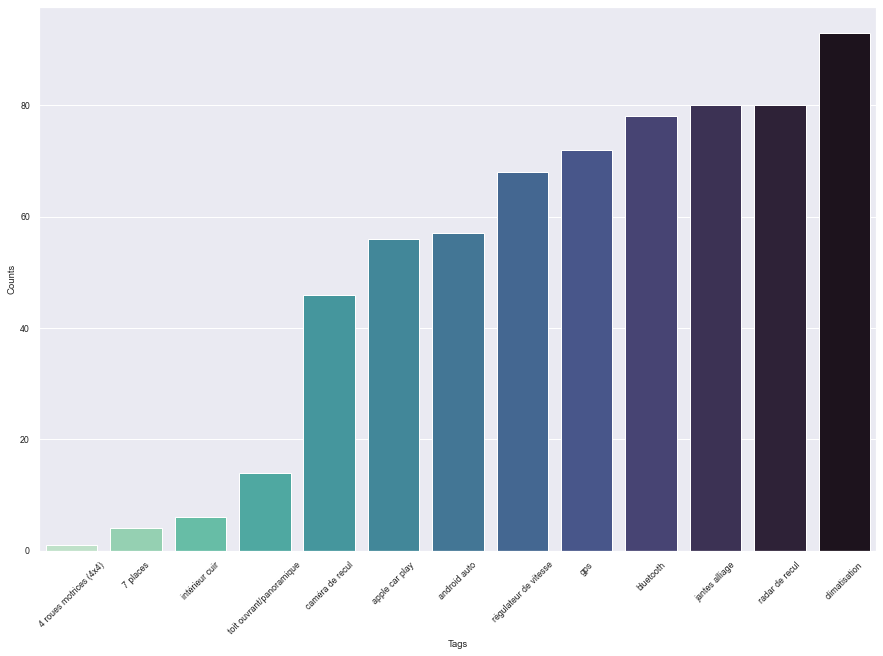

In [14]:
# visualisation des tags sur un diagramme en bar
sns.set(rc = {'figure.figsize':(15,10)})
sns.set(font_scale=0.8)
plt.xticks(rotation=45)
ax = sns.barplot(x='Tags', y='Counts', data=tag_df, order=tag_df.sort_values('Counts').Tags, palette='mako_r')

In [15]:
print("Nombre de climatisation : ", tag_df.iloc[6]['Counts'])
print("Nombre de radar de recul : ", tag_df.iloc[10]['Counts'])
print("Nombre de jantes alliage : ", tag_df.iloc[9]['Counts'])

Nombre de climatisation :  93
Nombre de radar de recul :  80
Nombre de jantes alliage :  80


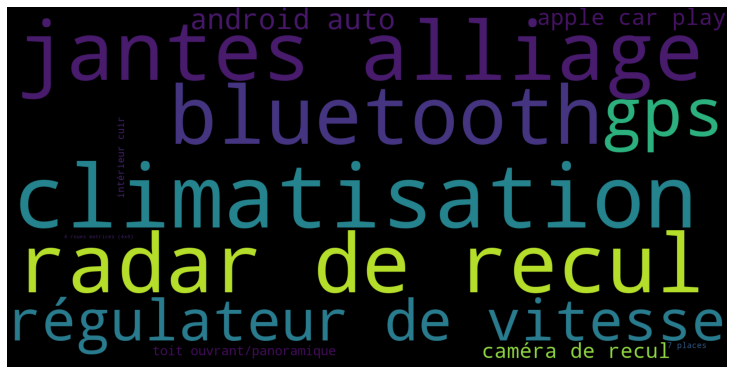

In [16]:
# visualisation des tags les plus fréquents en utilisant WordCloud
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize=(10,5))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

**Observations :**


1. "Climatisation", "radar de recul", "jantes alliage", "blueetooth", "gps" sont les tags les plus fréquents.
2. Puisque la plupart des tags apparaissent plus que d'autres, le micro-averaged F1-score est la métrique la plus approppriée au problème.

Désormais, on souhaite avoir des statistiques sur chaque tag et pouvoir établir s'il existe des tags corrélés entre eux en faisant un heatmap.

In [17]:
# Réinitialiser le dataframe pour pouvoir utiliser MultiLabelBinarizer()
df = pd.read_csv('cars_data.csv', sep=";")
df = df.drop(['export_date', 'offer_brand', 'offer_model','offer_technical_motorization_value'] , axis=1)
df = df.drop(['offer_database_id'],axis=1)
df = df[:99]

# on crée une colonne pour chaque tag où la valeur est binaire (1 : équipement présent ; 0 : équipement absent)
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df.loc[i,'main_equipments']).split(', ') for i in range(len(df))])
df = pd.concat([df['all_equipments'],pd.DataFrame(mlb_result,columns=(mlb.classes_))],axis=1)

In [18]:
# Avoir des statistiques sur chaque tag
df.describe()

,4 roues motrices (4x4),7 places,Android Auto,Apple Car Play,Bluetooth,Caméra de recul,Climatisation,GPS,Intérieur cuir,Jantes alliage,Radar de recul,Régulateur de vitesse,Toit ouvrant/panoramique
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.010101,0.040404,0.606061,0.595960,0.797980,0.474747,0.969697,0.747475,0.060606,0.838384,0.828283,0.696970,0.141414
std,0.100504,0.197907,0.491108,0.493203,0.403551,0.501903,0.172292,0.436672,0.239821,0.369972,0.379054,0.461907,0.350222
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


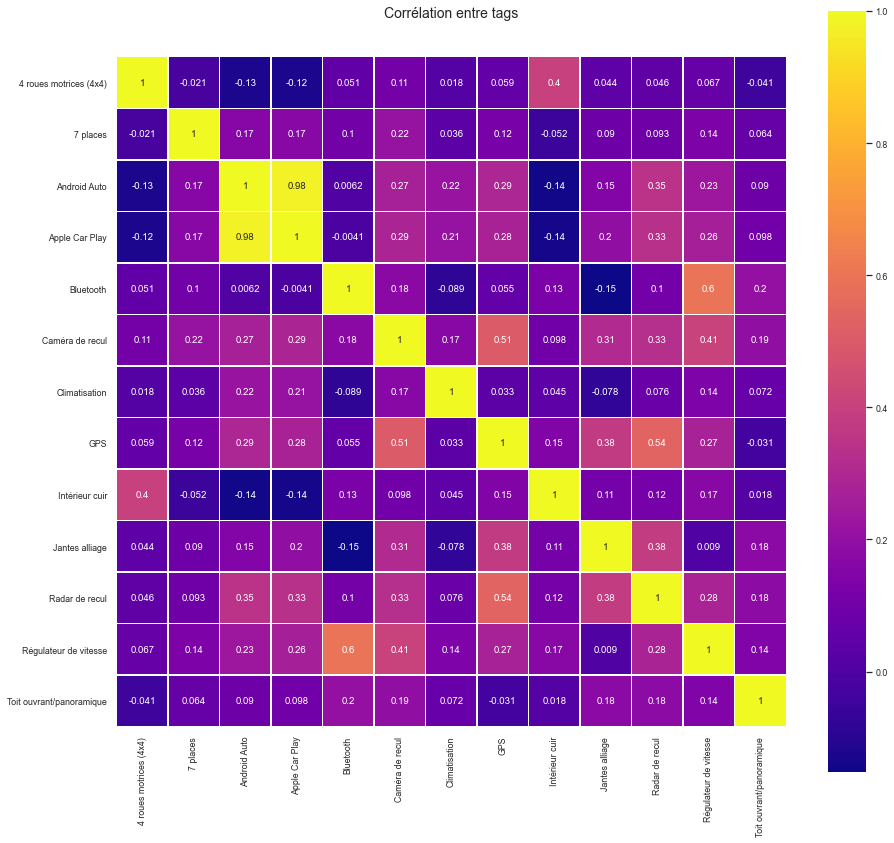

In [19]:
# création du heatmap
cols_target = ['4 roues motrices (4x4)',
 '7 places',
 'Android Auto',
 'Apple Car Play',
 'Bluetooth',
 'Caméra de recul',
 'Climatisation',
 'GPS',
 'Intérieur cuir',
 'Jantes alliage',
 'Radar de recul',
 'Régulateur de vitesse',
 'Toit ouvrant/panoramique']
data = df[cols_target]
colormap = plt.cm.plasma
plt.figure(figsize=(15,14))
plt.title('Corrélation entre tags', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)
plt.show()

**Observations :**

Il existe peu de corrélation entre tags. Le seul couple ayant une forte corrélation (0.98 qui est proche de 1) est le couple ('Android Auto', 'Apple Car Play'). Cela signifie qu'une voiture possédant une android auto aura de forte chance de posséder aussi un apple car play et vice versa.

## Normalisation des données <a name="paragraph4"></a>

Une fois l'exploration des données faite, on souhaite normaliser les données de l'attribut 'all_equipments'. Il s'agit de retirer les caractères spéciaux ; de transformer tous les caractères en minuscule ; de retirer les stopwords (mots inutiles pour la prédiction) ; d'appliquer du stemming (retirer quelques caractères de chaque mot)

In [20]:
# on réinitialise le dataframe
df = pd.read_csv('cars_data.csv', sep=";")
df = df.drop(['export_date', 'offer_brand', 'offer_model','offer_technical_motorization_value'] , axis=1)
df = df.drop(['offer_database_id'],axis=1)
df = df[:99]
df

# list_tpr va contenir tous les équipments propres
list_tpr = [] 

# préparer les données
for i in range(0, len(df)):
    descr = re.sub('[^a-zA-Z]', ' ', str(df['all_equipments'].iloc()[i]))
    descr = descr.lower()
    descr = descr.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('french')
    descr = [ps.stem(word) for word in descr if not word in set(all_stopwords)]
    descr = ' '.join(descr)
    list_tpr.append(descr)

In [21]:
# l'attribut 'all_equipments' prend toutes les données textuelles de list_tpr
df['all_equipments']  = list_tpr

In [22]:
# visualisation des résultats 
df.head()

,all_equipments,main_equipments
0,visiopark cam ra recul restitut cran tactil vu...,"Android Auto, Apple Car Play, Bluetooth, Camér..."
1,aid stationn ar air conditionn automatiqu bi z...,"Android Auto, Apple Car Play, Bluetooth, Camér..."
2,allumag automatiqu feux croisement direct assi...,"Bluetooth, Climatisation, Régulateur de vitess..."
3,r troviseur ext rieur rabatt lectriqu clairag ...,"Bluetooth, Jantes alliage"
4,kit anti crevaison clenchement automatiqu phar...,"7 places, Android Auto, Apple Car Play, Blueto..."


## Extraction des échantillons <a name="paragraph5"></a>

Maintenant, on définit X : l'attribut à exploiter pour prédire. Et y : la prédiction

De plus, on définit un jeu de données d'apprentissage (80% des données) et de test (20% des données).

In [23]:
# définition de X et y
df['main_equipments'] = df['main_equipments'].apply(lambda x: str(x).split(", "))
X = df.iloc[:,0].values
y = df.iloc[:,1].values
X = X[:99]
y = y[:99]


# définition du jeu de données d'apprentissage et de test
X_train, X_test, y_train_text, y_test_text = train_test_split(X,y, test_size = 0.2,  random_state=0)
print("Nombre de données dans le jeu de données d'apprentissage :", X_train.shape[0])
print("Nombre de données dans le jeu de données de test :", X_test.shape[0])

# S'assurer que chaque tag est entre guillemets pour y_train_text et y_test_text
# Par exemple : transformer ['Bluetooth, GPS'] en ['Bluetooth', 'GPS']
# Dans le but de rendre le jeu de données de test exploitable par le modèle de prédiction
Y_train_text = []
for i in range(0,len(y_train_text)):
    Y_train_text.append(", ".join(y_train_text[i]))
Y_train_text

for i in range(0,len(Y_train_text)):
    Y_train_text[i] = Y_train_text[i].split(', ')

Y_test_text = []
for i in range(0,len(y_test_text)):
    Y_test_text.append(", ".join(y_test_text[i]))

for i in range(0,len(Y_test_text)):
    Y_test_text[i] = Y_test_text[i].split(', ')

Nombre de données dans le jeu de données d'apprentissage : 79
Nombre de données dans le jeu de données de test : 20


## Modèle de prédiction <a name="paragraph6"></a>

### Un problème de multi-label

Nous voulons savoir quel genre de problème correspond ce cas pratique. En regardant de plus près quelques éléments de 'all_equipments', on s'aperçoit qu'il existe des mots identiques à ceux des tags comme 'caméra de recul', 'jantes alliage' et 'bluetooth'. Par contre, il existe des tags non identiques à l'ensemble des mots comme 'GPS', 'android auto et 'apple pay car'. C'est pourquoi ce problème semble être du keyword extraction, c'est-à-dire pouvoir extraire les mots les plus importants. Mais puisque certains tags n'apparaissent pas dans l'ensemble des mots d'une description, il s'agit en réalité d'un problème de **multi-label**. Ainsi, on cherche à attributer des tags à des descriptions de voitures.

Dans ce cadre, nous allons utiliser comme modèle de prédiction OneVsRestClassifier(LinearSVC()) de sklearn. 

Le modèle considèrera chaque tag comme étant un modèle de classification binaire. Ainsi, le modèle classifie chaque tag un par un et l'attribut la valeur 1 ou 0. Il s'agit du Binary Relevance, pour plus de détails : http://scikit.ml/api/skmultilearn.problem_transform.br.html.

Le deep learning semble être une mauvaise option car la taille de l'échantillon est maigre (100 voitures), or, pour que le deep learning ait des résultats efficaces, il nous faut une taille colossale de données.

Ensuite, on mesure les performanes par les métriques suivantes : l'accuracy score, le macro-averaged F1-score, le micro-averaged F1-score et le hamming loss.

Comme on l'a énoncé plus tôt, la métrique la plus pertinante est le micro-averaged F1-score.

In [24]:
# créer une instance de MultiLabelBinarizer
mlb = preprocessing.MultiLabelBinarizer(classes=('4 roues motrices (4x4)', '7 places', 'Android Auto',
 'Apple Car Play',
 'Bluetooth',
 'Caméra de recul',
 'Climatisation',
 'GPS',
 'Intérieur cuir',
 'Jantes alliage',
 'Radar de recul',
 'Régulateur de vitesse',
 'Toit ouvrant/panoramique'))

# le mlb s'adapte au jeu de données de test
Y = mlb.fit_transform(Y_train_text)
Y_test = mlb.fit_transform(Y_test_text)

# créer le modèle en vectorisant les mots par CountVectorizer() et TfidfTransformer()
# ce modèle s'appuie sur la technique de classificaiton SVM 
classifier = Pipeline([
('vectorizer', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf', OneVsRestClassifier(LinearSVC()))])

# le modèle s'adapte au jeu de données
classifier.fit(X_train, Y)

# predicted est la matrice de prédiction de X_test
predicted = classifier.predict(X_test)

# établir des métriques 
print("Accuracy score : ",accuracy_score(Y_test, predicted))
print("Macro-averaged f1 score :",metrics.f1_score(Y_test, predicted, average = 'macro'))
print("Micro-averaged f1 score :",metrics.f1_score(Y_test, predicted, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(Y_test, predicted))

Accuracy score :  0.25
Macro-averaged f1 score : 0.5654999237746325
Micro-averaged f1 score : 0.8326848249027238
Hamming loss : 0.16538461538461538


C:\Users\Michel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


**Observations :**

1. Le micro-averaged f1-score vaut 0.83, ce qui est proche de 1. Donc le modèle semble offrir de bonnes performances.
2. Cela dit, le hamming loss vaut 0.16, ce qui signie que le modèle a 16% de chances de prédire un mauvais tag parmi tous les tags qu'il prédit.

In [25]:
# visualisation des résultats sur le jeu de données de test
# la première ligne correspond aux prédictions
# la seconde ligne correspond aux réelles descriptions
for i in range (0,len(X_test)):
    predicted = classifier.predict([X_test[i]])
    all_labels = mlb.inverse_transform(predicted)
    for item, labels in zip(X_test[i], all_labels):
        print(' => {1} '.format(item, ', '.join(labels)))
        print(Y_test_text[i])
        print('_'*120)

 => Android Auto, Apple Car Play, Climatisation, GPS, Jantes alliage, Radar de recul 
['Android Auto', 'Apple Car Play', 'Climatisation', 'GPS', 'Jantes alliage', 'Radar de recul']
________________________________________________________________________________________________________________________
 => Bluetooth, Climatisation, Jantes alliage, Régulateur de vitesse 
['Bluetooth', 'Climatisation', 'GPS', 'Jantes alliage', 'Régulateur de vitesse', 'Radar de recul']
________________________________________________________________________________________________________________________
 => Bluetooth, Climatisation, Jantes alliage, Radar de recul 
['Bluetooth', 'Climatisation', 'Régulateur de vitesse', 'Radar de recul']
________________________________________________________________________________________________________________________
 => Bluetooth, Caméra de recul, Climatisation, GPS, Jantes alliage, Radar de recul, Régulateur de vitesse 
['Climatisation', 'GPS', 'Jantes alliage', 'R

## API <a name="paragraph7"></a>

Pour finir, on souhaite créer une interface web dans laquelle un utilisateur peut insérer une liste exhaustive d'équipments et peut prédire les équipments principaux.

### Sauvegarde du modèle

A l'aide de la librairie pickle, on sauvegarde le modèle.


**POUR QUE L'API FONCTIONNE, IL FAUT D'ABORD EXECUTER LA CASE SITUÉE EN DESSOUS POUR ENREGISTRER LE MODELE DANS UN FICHIER 'CLASSIFIER.SAV'. ENSUITE, IL FAUT EXECUTER LE NOTEBOOK API.**

In [26]:
# sauvegarder le modèle dans un fichier 'classifier.sav'
filename = 'classifier.sav'
pickle.dump(classifier, open(filename, 'wb'))
load_classifier = pickle.load(open(filename, 'rb'))

## Références <a name="paragraph8"></a>

1. "Multi-label classification for Tag predictions" par vikashrajluhaniwal


https://www.kaggle.com/vikashrajluhaniwal/multi-label-classification-for-tag-predictions

2. "Classifying multi-label comments (0.9741 lb)" par Hoon Beng


https://www.kaggle.com/rhodiumbeng/classifying-multi-label-comments-0-9741-lb

3. "Stop the S@#$ - Toxic Comments EDA" par Jagan


https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda 

4. "Machine Learning Model Deployment using Flask | Flask RESTFUL API" par Satyajit Pattnaik


https://www.youtube.com/watch?v=MAu1fPqlivk